In [2]:
#! usr/bin/env python3

## Code for classifying word data from:
https://python.gotrained.com/text-classification-with-pandas-scikit/

In [3]:
import pandas as pd
import datetime as dt
from wordcloud import WordCloud
import PIL
import itertools
import matplotlib.pyplot as plt
import re
import operator
import numpy as np
import seaborn as sns

## Import data downloaded from reddit

In [4]:
new_data_mommit = pd.read_pickle('mommit_data')
new_data_bump2017 = pd.read_pickle('bump2017_data')
new_data_ppd = pd.read_pickle('ppd_data')
new_data_babies = pd.read_pickle('babies_data')

In [5]:
## Define stop words (words useless in analysis)
stop_words =['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself',
            'yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself',
            'they','them','their','theirs','themselves','what','which','who','whom','this','that',
            'these','those','am','is','are','was','were','be','been','being','have','has','had',
            'having','do','does','did','doing','a','an','the','and','but','if','or','because','as',
            'until','while','of','at','by','for','with','about','against','between','into','through',
            'during','before','after','above','below','to','from','up','down','in','out','on','off',
            'over','under','again','further','then','once','here','there','when','where','why','how',
            'all','any','both','each','few','more','most','other','some','such','no','nor','not',
            'only','own','same','so','than','too','very','s','t','can','will','just','don','should',
            'now','uses','use','using','used','one','also','r',
        'baby','week','mom','moms','dad','pregnancy','pregnant','thread','chat','daily',
    'monday','tuesday','wednesday','thursday','friday','saturday','sunday',
            'mondays','tuesdays','wednesdays','thursdays','fridays','saturdays','sundays','year','old']
    
## Function to remove stop words    
def preprocess(data):
    data = data.lower() #Convert to lower-case words
    raw_word_tokens = re.findall(r'(?:\w+)', data)#,flags = re.UNICODE) #remove pontuaction
    word_tokens = [w for w in raw_word_tokens if not w in stop_words] # do not add stop words
    return word_tokens #return all tokens

Plot of comment number by posts metioning the key word depression in various subgroups

Text(0.5,1,'PPD support subreddit')

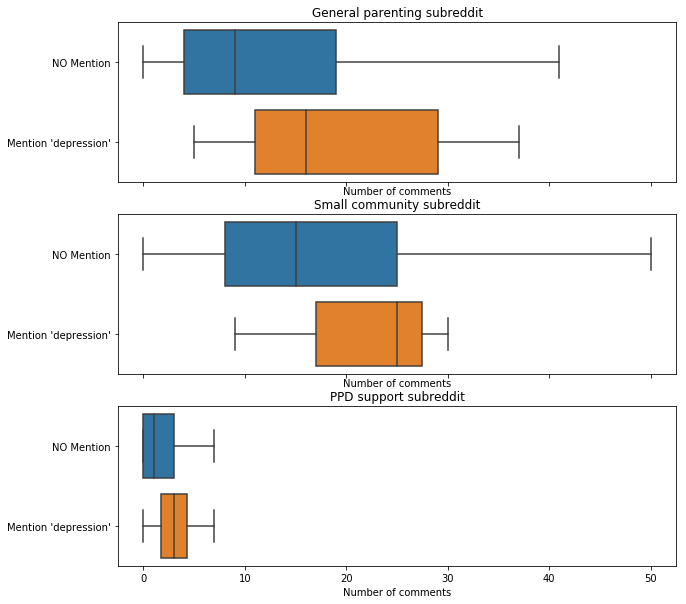

In [6]:
def word_occurence_col(data,test_words):
    tslist = list()
    flag = False
    for i,bodytext in enumerate(data):
        for word in preprocess(bodytext):
            if word in test_words:
                flag = True
        if flag: tslist.append('Mention \'depression\'')
        else: tslist.append('NO Mention')
        flag = False
    return tslist

test_words = ['depression']

fig = plt.figure(figsize = (10,10))
ax = fig.subplots(3,1, sharex = True, sharey = True)

for i in range(3):
    if i == 0: dat = new_data_mommit
    elif i == 1: dat = new_data_bump2017
    elif i == 2: dat = new_data_ppd
    dat['word_use_count'] = word_occurence_col(dat['body'],test_words)
    sns.boxplot(x = 'comms_num', y = 'word_use_count', data = dat, ax = ax[i],showfliers = False,orient = 'h')
    ax[i].set_xlabel('Number of comments')
    ax[i].set_ylabel('')

    
ax[0].set_title('General parenting subreddit')
ax[1].set_title('Small community subreddit')
ax[2].set_title('PPD support subreddit')


## Classification of posts
with code and NLP procedure from: https://python.gotrained.com/text-classification-with-pandas-scikit/

Create training dataset from posts in two specific subreddits (a specific ppd-support group vs a neutral 'babies' group)

In [7]:
df_train = new_data_ppd[['body','title']]
df_train['subR'] = 'ppd'
new_data_babies['subR'] = 'neutral'
df_train= df_train.append(new_data_babies[['body','title','subR']])

/home/asya/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
def preprocess_nosplit(data):
    reviews_tokens = []
    for review in data:
        review = review.lower() #Convert to lower-case words
        raw_word_tokens = re.findall(r'(?:\w+)', review,flags = re.UNICODE) #remove puntuaction
        word_tokens = [w for w in raw_word_tokens if not w in stop_words] # do not add stop words
        reviews_tokens.append(word_tokens)
    return reviews_tokens #return all tokens

def featurize(sentence_tokens,bag_of_words):
    sentence_features = [0 for x in range(len(bag_of_words))]
 
    for word in sentence_tokens:
        index = bag_of_words[word]
        sentence_features[index] +=1
    return sentence_features

def construct_bag_of_words(data):
    bag_of_words = {}
    word_count = 0
    corpus =  preprocess_nosplit(data)
    for sentence in corpus:
        for word in sentence:
            if word not in bag_of_words: # do not allow repetitions
                bag_of_words[word] = word_count #set indexes
                word_count+=1
    return bag_of_words #index of letters


def get_batch_features(data,bag_of_words):
    batch_features = []
    reviews_text_tokens = preprocess_nosplit(data)
    for review_text in reviews_text_tokens:
        feature_review_text = featurize(review_text,bag_of_words)
        batch_features.append(feature_review_text)
    return batch_features

In [9]:
df_all_words = df_train['title'].append(new_data_mommit['title'])
df_all_words = df_all_words.append(new_data_bump2017['title'])
df_all_words = df_all_words.append(new_data_mommit['body'])
df_all_words = df_all_words.append(new_data_bump2017['body'])
df_all_words = df_all_words.append(df_train['body'])

bag_of_words = construct_bag_of_words(df_all_words)
batch_features = get_batch_features(df_train['title'],bag_of_words)

Train and test a classifier to separate posts

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(batch_features, df_train['subR'], test_size=0.33, random_state=42)

#clf = RandomForestClassifier()
clf = MultinomialNB()

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.922


In [29]:
bump_features = get_batch_features(new_data_bump2017['body'],bag_of_words)
new_data_bump2017['predict_type'] = clf.predict(bump_features)

bump_features = get_batch_features(new_data_mommit['body'],bag_of_words)
new_data_mommit['predict_type'] = clf.predict(bump_features)

Create word cloud visualization of post content based on classification in a main subreddit

Text(0.5,1,'PPD-related post text')

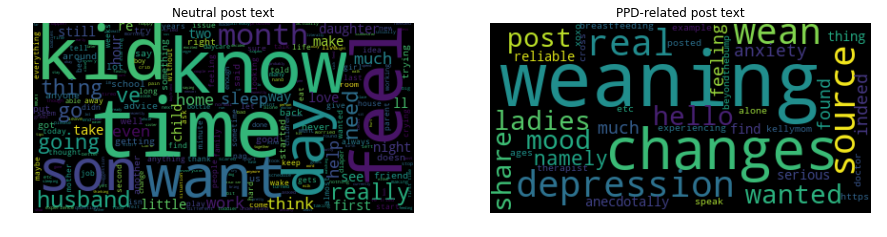

In [31]:
## Create word cloud
fig = plt.figure(figsize = (15,5))
ax = fig.subplots(1,2)


all_words = []
for bodytext in new_data_mommit[new_data_mommit['predict_type'] == 'neutral']['body']:
    all_words = all_words + preprocess(bodytext)
all_text = " ".join(all_words)
wordcloud = WordCloud(max_words=5000,margin=0).generate(all_text)

ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title('Neutral post text')

## Create word cloud
all_words = []
for bodytext in new_data_mommit[new_data_mommit['predict_type'] == 'ppd']['body']:
    all_words = all_words + preprocess(bodytext)
all_text = " ".join(all_words)
wordcloud = WordCloud(max_words=5000,margin=0).generate(all_text)
ax[1].imshow(wordcloud, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('PPD-related post text')


## Further goals:

analyze content of comments for ppd-related posts (and include a larger dataset)